In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

file_id = '10Guj_0Hnl_4ml1phbqkjrxGaxvvSZd9Y'
fname = os.path.join(local_download_path, 'student_data.csv')
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(fname)

In [179]:
!ls data

student_data.csv


In [180]:
# Importing pandas and numpy
import pandas as pd
import numpy as np

# Reading the csv file into a pandas DataFrame
data = pd.read_csv('~/data/student_data.csv')

# Printing out the first 10 rows of our data
data[:10]

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2
6,1,560,2.98,1
7,0,400,3.08,2
8,1,540,3.39,3
9,0,700,3.92,2


## Plotting the data

First let's make a plot of our data to see how it looks. In order to have a 2D plot, let's ingore the rank.

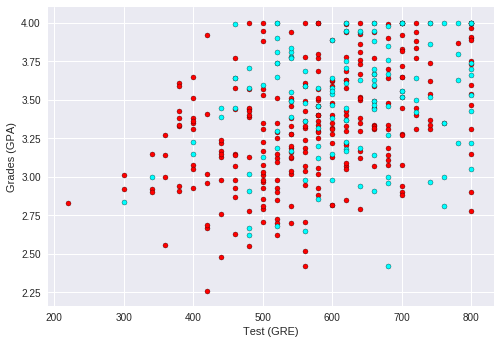

In [181]:
# Importing matplotlib
import matplotlib.pyplot as plt

# Function to help us plot
def plot_points(data):
    X = np.array(data[["gre","gpa"]])
    y = np.array(data["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    
# Plotting the points
plot_points(data)
plt.show()

Roughly, it looks like the students with high scores in the grades and test passed, while the ones with low scores didn't, but the data is not as nicely separable as we hoped it would. Maybe it would help to take the rank into account? Let's make 4 plots, each one for each rank.

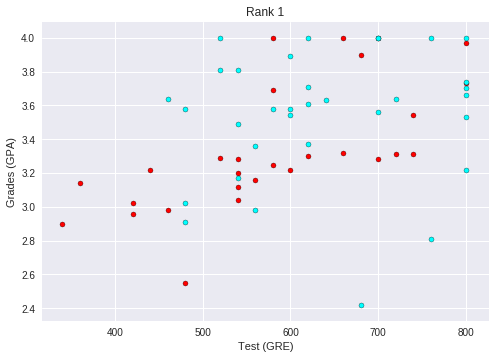

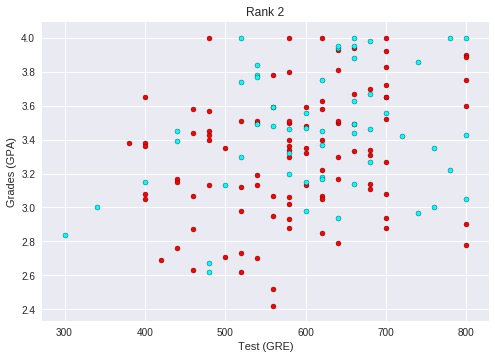

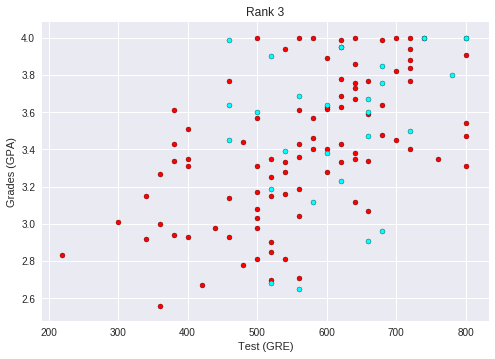

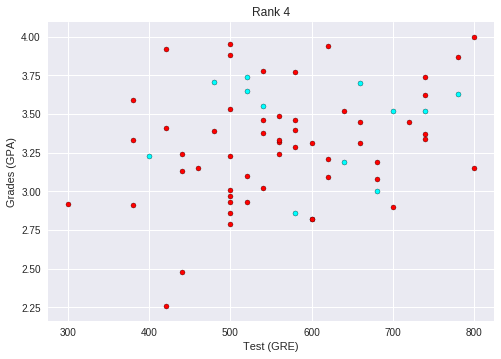

In [182]:
# Separating the ranks
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

# Plotting the graphs
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
plot_points(data_rank2)
plt.title("Rank 2")
plt.show()
plot_points(data_rank3)
plt.title("Rank 3")
plt.show()
plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

This looks more promising, as it seems that the lower the rank, the higher the acceptance rate. Let's use the rank as one of our inputs. In order to do this, we should one-hot encode it.

## One-hot encoding the rank
For this, we'll use the `get_dummies` function in pandas.

In [183]:
# Make dummy variables for rank
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)

# Drop the previous rank column
one_hot_data = one_hot_data.drop('rank', axis=1)

# Print the first 10 rows of our data
one_hot_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1
5,1,760,3.00,0,1,0,0
6,1,560,2.98,1,0,0,0
7,0,400,3.08,0,1,0,0
8,1,540,3.39,0,0,1,0
9,0,700,3.92,0,1,0,0


## Scaling the data
The next step is to scale the data. We notice that the range for grades is 1.0-4.0, whereas the range for test scores is roughly 200-800, which is much larger. This means our data is skewed, and that makes it hard for a neural network to handle. Let's fit our two features into a range of 0-1, by dividing the grades by 4.0, and the test score by 800.

In [184]:
# Copying our data
processed_data = one_hot_data[:]

# Scaling the columns
processed_data['gre'] = processed_data['gre']/800
processed_data['gpa'] = processed_data['gpa']/4.0
processed_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,0.475,0.9025,0,0,1,0
1,1,0.825,0.9175,0,0,1,0
2,1,1.000,1.0000,1,0,0,0
3,1,0.800,0.7975,0,0,0,1
4,0,0.650,0.7325,0,0,0,1
5,1,0.950,0.7500,0,1,0,0
6,1,0.700,0.7450,1,0,0,0
7,0,0.500,0.7700,0,1,0,0
8,1,0.675,0.8475,0,0,1,0
9,0,0.875,0.9800,0,1,0,0


## Splitting the data into Training and Testing

In order to test our algorithm, we'll split the data into a Training and a Testing set. The size of the testing set will be 10% of the total data.

In [185]:
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])

Number of training samples is 360
Number of testing samples is 40
     admit    gre     gpa  rank_1  rank_2  rank_3  rank_4
320      0  0.575  0.7850       0       0       1       0
237      0  0.600  1.0000       0       1       0       0
350      1  0.975  1.0000       0       1       0       0
55       1  0.925  1.0000       0       0       1       0
281      0  0.450  0.8175       0       0       1       0
326      0  0.850  0.8275       0       1       0       0
232      0  0.475  0.8450       0       1       0       0
12       1  0.950  1.0000       1       0       0       0
302      1  0.500  0.7875       0       1       0       0
324      0  0.650  0.6750       0       0       1       0
     admit    gre     gpa  rank_1  rank_2  rank_3  rank_4
16       0  0.975  0.9675       0       0       0       1
33       1  1.000  1.0000       0       0       1       0
61       0  0.700  0.8300       0       0       0       1
91       1  0.900  0.9100       1       0       0       0
93    

## Splitting the data into features and targets (labels)
Now, as a final step before the training, we'll split the data into features (X) and targets (y).

Also, in Keras, we need to one-hot encode the output. We'll do this with the `to_categorical function`.

In [186]:
import keras

# Separate data and one-hot encode the output
# Note: We're also turning the data into numpy arrays, in order to train the model in Keras
features = np.array(train_data.drop('admit', axis=1))
targets = np.array(keras.utils.to_categorical(train_data['admit'], 2))
features_test = np.array(test_data.drop('admit', axis=1))
targets_test = np.array(keras.utils.to_categorical(test_data['admit'], 2))

print(features[:10])
print(targets[:10])

[[0.575  0.785  0.     0.     1.     0.    ]
 [0.6    1.     0.     1.     0.     0.    ]
 [0.975  1.     0.     1.     0.     0.    ]
 [0.925  1.     0.     0.     1.     0.    ]
 [0.45   0.8175 0.     0.     1.     0.    ]
 [0.85   0.8275 0.     1.     0.     0.    ]
 [0.475  0.845  0.     1.     0.     0.    ]
 [0.95   1.     1.     0.     0.     0.    ]
 [0.5    0.7875 0.     1.     0.     0.    ]
 [0.65   0.675  0.     0.     1.     0.    ]]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


# Predicting Student Admissions with Neural Networks in Keras
In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

## Loading the data
To load the data and format it nicely, we will use two very useful packages called Pandas and Numpy. You can read on the documentation here:
- https://pandas.pydata.org/pandas-docs/stable/
- https://docs.scipy.org/

## Defining the model architecture
Here's where we use Keras to build our neural network.

In [187]:
# Imports
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

# Building the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(6,)))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(2, activation='softmax'))

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 128)               896       
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 130       
Total params: 9,282
Trainable params: 9,282
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [188]:
# Training the model
model.fit(features, targets, epochs=300, batch_size=100, verbose=0)

## Scoring the model

In [189]:
# Evaluating the model on the training and testing set
score = model.evaluate(features, targets)
print("\n Training Accuracy:", score[1])
score = model.evaluate(features_test, targets_test)
print("\n Testing Accuracy:", score[1])

360/360 [==============================] - 0s 523us/step

 Training Accuracy: 0.7194444444444444
40/40 [==============================] - 0s 234us/step

 Testing Accuracy: 0.625


## Challenge: Play with the parameters!
You can see that we made several decisions in our training. For instance, the number of layers, the sizes of the layers, the number of epochs, etc.
It's your turn to play with parameters! Can you improve the accuracy? The following are other suggestions for these parameters. We'll learn the definitions later in the class:
- Activation function: relu and sigmoid
- Loss function: categorical_crossentropy, mean_squared_error
- Optimizer: rmsprop, adam, ada

**Comparison:** 
</br> </br>

**Cross Entropy / RELU / ADAM:**

360/360 [==============================] - 0s 178us/step

 Training Accuracy: 0.725
40/40 [==============================] - 0s 212us/step

 Testing Accuracy: 0.575

</br>

**Cross Entropy / Sigmoid / ADAM:**

360/360 [==============================] - 0s 243us/step

 Training Accuracy: 0.6888888888888889
40/40 [==============================] - 0s 226us/step

 Testing Accuracy: 0.725
 
</br>
 
**Mean Squared Error / RELU / ADAM:**
360/360 [==============================] - 0s 285us/step

 Training Accuracy: 0.7111111111111111
40/40 [==============================] - 0s 242us/step

 Testing Accuracy: 0.65
 
</br>

 **Cross Entropy / RELU / RMSProp:**
360/360 [==============================] - 0s 285us/step

 Training Accuracy: 0.7111111111111111
40/40 [==============================] - 0s 242us/step

 Testing Accuracy: 0.65
 

